### PROJECT TITLE: 
##### SHARP TURN DETECTION LOGIC FOR TRUCKS

### INTRODUCTION: 
##### Sharp turns pose rollover and accident risks for trucks due to their size. 
##### Detecting sharp turn events allows preemptive safety measures, including driver warnings and stability control activation.

### METHODS: 
##### 1. No Aggregation & Radius Estimated from Truck Length
##### 2. Aggregation (10 seconds Mean & Radius Estimated from Truck Speed)
##### 3. Aggregation (Constant Angular Velocity over 10 seconds & Radius Estimated from Truck Speed)


--------------------------------------------------

#### ALL REQUIRED LIBRARIES

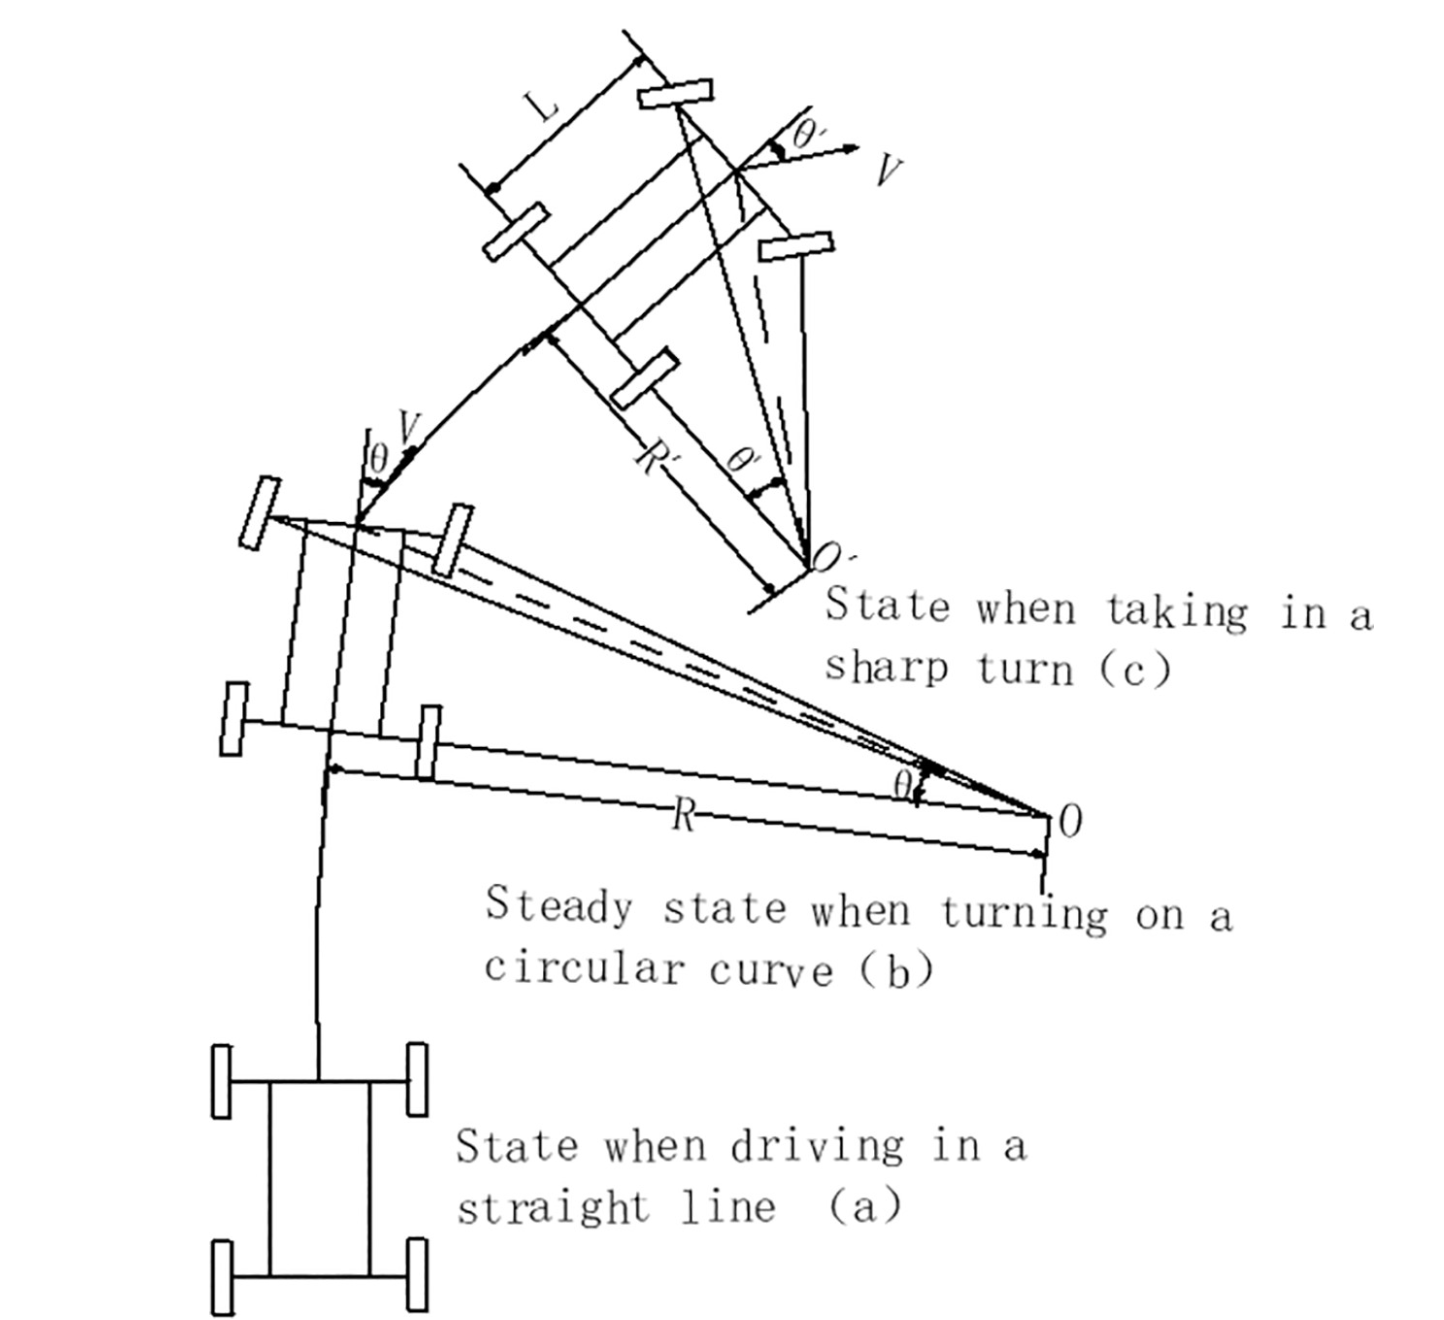

In [23]:
import numpy as np                              
import pandas as pd                            
import matplotlib.pyplot as plt
from IPython.display import Image, display

from datetime import datetime                                                                        
from math import radians, cos, sin, asin, sqrt
import math
import warnings 
warnings.filterwarnings('ignore')

display(Image(filename='./Images/Radius_of_curve.png', width=600, height=100))


------

### MODEL ASSUMPTIONS 

#### - Investigation and analysis is centered around Conventional Truck heads and Reefers

#### - Typical height of center of gravity of truck head is 0.8 m range (0.6 - 0.9)
#### - Typical truck head weight - 9071.84 Kg (20,000 lbs)
#### - Typical trailer weight and loading conditions
    Empty - 6123 kg (13,500 lbs) 

    Partially Full 14,000 kg (30,864.7lbs)

    Full - 22679.619 kg (50,000 lbs)

#### Superelevation of road to calculate center of gravity is 0.35m

#### Formula for estimating constants for Height of Center of Gravity (HCG) of Typical Truck type

$$\theta = \sin^{-1}(\frac{h}{L})$$
$$\gamma = \cot(\theta)$$
$$h = [b-L(\frac{R_{rl}}{w})]\gamma + r $$


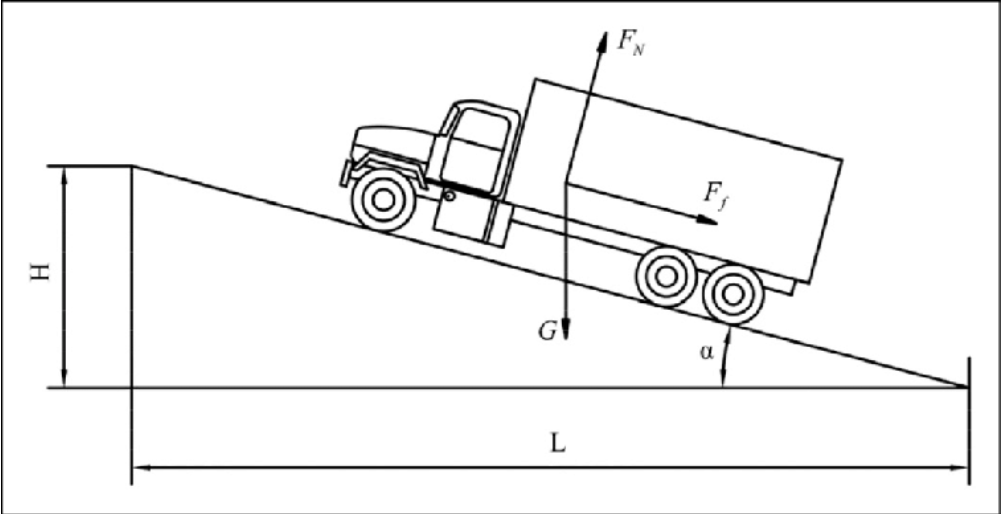

In [24]:
display(Image(filename='./Images/hcg_image.png', width=500, height=200))

In [25]:
mass_truckhead = 9071.85
mass_reeftrailor = 22679.619
semi_trackwidth =  2.47
height_of_center_of_gravity_truckhead = 0.8
height_of_center_of_gravity_trailer = 1.35
gravity = 9.81
truck_length = 25

---

#### LOADING AND EXPLORING THE ELD DATA

In [26]:
headers = ['timestamp','latitude','longitude','direction','vehicle_motion_status','speed_mph','acceleration_from_gps_speed']
gps_df = pd.read_csv('sample_gps_data/sim.csv')
gps_df.columns = headers
gps_df_10 = gps_df.copy() #  Creating a copy of the dataframe to be used in subsequent methods
gps_df_cav = gps_df.copy() #  Creating a copy of the dataframe to be used in subsequent methods
gps_df.head(4)

,timestamp,latitude,longitude,direction,vehicle_motion_status,speed_mph,acceleration_from_gps_speed
0,2023-11-20 10:50:34.000,42.35762,-83.11444,123.68,MOVING,74.0,-0.42
1,2023-11-20 10:50:35.000,42.35745,-83.11412,123.45,MOVING,72.9,-0.47
2,2023-11-20 10:50:36.000,42.35730,-83.11381,123.27,MOVING,72.9,0.00
3,2023-11-20 10:50:37.000,42.35712,-83.11349,123.49,MOVING,72.5,-0.19


#### DATA PROCESSING AND FEATURE ENGINEERING

In [27]:
def date_time(date_time_str):
    # Convert the date-time string to a usable format
    t = str(date_time_str)
    # Split the string to separate date and time parts
    parts = t.split('.')
    
    # Extract the date and time information
    clean = parts[0].split(' ')
    date_parts = clean[0].split('-')
    time_parts = clean[1].split(':')
    
    # Convert date and time parts to integers
    date_parts = map(int, date_parts)
    time_parts = map(int, time_parts)

    # Extract individual components (year, month, day, hour, minute, second)
    year, month, day = date_parts
    hour, minute, second = time_parts
    
    # Create a datetime object
    date_time_obj = datetime(year, month, day, hour, minute, second)

    # Calculate the total seconds since the Unix epoch (1970-01-01)
    total_seconds = (date_time_obj - datetime(1970, 1, 1)).total_seconds()
    
    return total_seconds


In [28]:
def angular_distance(angle1, angle2):
    # Ensure both angles are between 0 and 360 degrees
    angle1 = angle1 % 360.0
    angle2 = angle2 % 360.0
    
    # Calculate the absolute angular distance
    distance = abs(angle1 - angle2)
    
    # Take the minimum of the direct distance and the wrapped-around distance
    distance = min(distance, 360.0 - distance)
    
    # Convert to radians
    distance_radians = distance * (np.pi / 180)
    
    # Return the calculated angular distance in radians
    return distance_radians

In [29]:
# Shift the direction column to get the previous heading
gps_df['previous_heading'] = gps_df['direction'].shift()

# Calculate the angular distance between consecutive headings
gps_df['angular_distance'] = gps_df.apply(lambda row: angular_distance(row['previous_heading'], row['direction']), axis=1)

# Calculate angular velocity (angularV) using the angular distance and time difference
gps_df["angularV"] = (gps_df.angular_distance) / gps_df.timestamp.apply(date_time).diff()

# Drop the columns not required further and temporary column used for calculating angular distance
gps_df.drop(columns=['latitude','longitude','acceleration_from_gps_speed','previous_heading'],inplace=True)

# Display the first 4 rows of the DataFrame
gps_df.head(4)

,timestamp,direction,vehicle_motion_status,speed_mph,angular_distance,angularV
0,2023-11-20 10:50:34.000,123.68,MOVING,74.0,NaN,NaN
1,2023-11-20 10:50:35.000,123.45,MOVING,72.9,0.004014,0.004014
2,2023-11-20 10:50:36.000,123.27,MOVING,72.9,0.003142,0.003142
3,2023-11-20 10:50:37.000,123.49,MOVING,72.5,0.003840,0.003840


#### ESTIMATING RADIUS OF CURVE - R FROM ELD DATA

### $$r = v/w$$
##### r = radius
##### v = speed in m/s
##### w = angualer velocity

In [30]:
def find_curve_radius(angle_degrees, truck_length=truck_length):
    # Calculate the adjacent side of a right-angled triangle using the tangent of the angle
    # Adding a small value (0.00001) to avoid division by zero
    curve_radius = truck_length / (math.tan(angle_degrees) + 0.00001)
    
    # Return the absolute value of the result
    return np.abs(curve_radius)

In [31]:
# Convert speed from mph to m/s
gps_df['speed_mps'] = gps_df['speed_mph'] * 0.44704

# Calculate curve radius using angular velocity
gps_df['CurveRadius'] = np.abs(gps_df['speed_mps'] / gps_df['angularV'])

# Calculate radius based on angular distance using the find_adjacent function
gps_df['radius'] = gps_df['angular_distance'].apply(find_curve_radius)

#### ESTIMATING TOTAL HEIGHT OF CENTER OF GRAVITY

$$h_{cm}=\frac{m_{truck}\cdot h_{truck} + m_{trailor} \cdot h_{trailor}}{m_{trailor}+m_{truck}}$$

In [32]:
h_cg = (mass_truckhead * height_of_center_of_gravity_truckhead \
        + mass_reeftrailor  * height_of_center_of_gravity_trailer)\
            /(mass_truckhead + mass_reeftrailor)

#### ESTIMATING THE THRESHOLD SPEED (V) FOR TYPICAL TRUCK TYPE

$$v_{\text{crit}} = \sqrt{\frac{g \cdot T}{2H_{cg}} \cdot r}$$

$$v_{\text{crit}} = \sqrt{127 \cdot R \cdot ({U_y} + {I_h})}$$

Where:  g = $9.81$, ${H_{cg}}$ = height of center of mass, T = track width of each truck


In [33]:
def critical_speed(radius, height=h_cg, track_width=semi_trackwidth):
    """Calculates the critical speed based on given parameters.

    Args:
        radius (float): Radius in meters.
        height (float): Height in meters.
        track_width (float): Track width in meters.

    Returns:
        float: Critical speed value in miles per hour.
    """
    g = 9.81
    # Calculate critical speed in m/s
    crit_speed = np.sqrt((g * track_width) / (2 * height) * radius)
    # Convert to miles per hour
    critical_speed_mph = crit_speed * 2.23694
    return critical_speed_mph


### METHOD 1  - NO AGGREGATION & USING RADIUS ESTIMATED FROM TRUCK LENGTH

In [34]:
# Calculate critical speed for each data point
gps_df['critical_speed'] = gps_df['radius'].apply(critical_speed)

# Create a column 'result' based on the condition: 85% of critical speed
gps_df['result'] = np.where(gps_df.critical_speed * 0.85 <= gps_df['speed_mph'], 1, 0)

# Display the first 4 rows of the dataframe
gps_df.head(4)

,timestamp,direction,vehicle_motion_status,speed_mph,angular_distance,angularV,speed_mps,CurveRadius,radius,critical_speed,result
0,2023-11-20 10:50:34.000,123.68,MOVING,74.0,NaN,NaN,33.080960,NaN,NaN,NaN,0
1,2023-11-20 10:50:35.000,123.45,MOVING,72.9,0.004014,0.004014,32.589216,8118.367541,6212.293179,561.893589,0
2,2023-11-20 10:50:36.000,123.27,MOVING,72.9,0.003142,0.003142,32.589216,10373.469636,7932.471218,634.939518,0
3,2023-11-20 10:50:37.000,123.49,MOVING,72.5,0.003840,0.003840,32.410400,8440.814238,6493.939606,574.489676,0


#### RESULTS AND CONCLUSION

In [48]:
# Find indices where 'result' is 1
indices_with_one = np.where(gps_df.result == 1)[0]

# Print statistics
print(f'Total Sharp Turns: --> {len(indices_with_one)}')
print(f'Total Hours: --> {len(gps_df) / 3600:.02f} Hrs')
print(f'Percentage: --> {(len(indices_with_one) / len(gps_df) * 100):.02f} %')
print(f'Indices {indices_with_one}')

Total Sharp Turns: --> 5
Total Hours: --> 20.73 Hrs
Percentage: --> 0.01 %
Indices [   11    12    23    24 15426]


In [46]:
gps_df[10:25]

,timestamp,direction,vehicle_motion_status,speed_mph,angular_distance,angularV,speed_mps,CurveRadius,radius,critical_speed,result
10,2023-11-20 10:50:44.000,133.54,MOVING,74.5,0.081681,0.081681,33.304480,407.736355,305.348917,124.573681,0
11,2023-11-20 10:50:45.000,148.25,MOVING,75.5,0.256738,0.256738,33.751520,131.462926,95.222989,69.566317,1
12,2023-11-20 10:50:46.000,133.68,MOVING,75.5,0.254294,0.254294,33.751520,132.726125,96.179208,69.914733,1
13,2023-11-20 10:50:47.000,128.23,MOVING,75.1,0.095120,0.095120,33.572704,352.949403,262.004066,115.393706,0
14,2023-11-20 10:50:48.000,123.52,MOVING,75.1,0.082205,0.082205,33.572704,408.402175,303.395551,124.174583,0
15,2023-11-20 10:50:49.000,123.29,MOVING,74.7,0.004014,0.004014,33.393888,8318.821061,6212.293179,561.893589,0
16,2023-11-20 10:50:50.000,123.92,MOVING,74.5,0.010996,0.010996,33.304480,3028.898639,2271.484680,339.768421,0
17,2023-11-20 10:50:51.000,123.70,MOVING,74.5,0.003840,0.003840,33.304480,8673.664286,6493.939606,574.489676,0
18,2023-11-20 10:50:52.000,123.78,MOVING,74.3,0.001396,0.001396,33.215072,23788.543023,17777.596886,950.527383,0
19,2023-11-20 10:50:53.000,130.04,MOVING,73.8,0.109258,0.109258,32.991552,301.961132,227.885031,107.618270,0



### Conclusion
    - With this method we returned some positive results indicating sharp turns with significant change in heading

---

### METHOD 2  -  AGGREGATION (10 SECONDS MEAN & RADIUS ESTIMATED FROM VELOCITY)

#### DATA PROCESSING AND FEATURE ENGINEERING

In [36]:
# Convert 'timestamp' to datetime format
gps_df_10['timestamp'] = pd.to_datetime(gps_df_10.timestamp)

# Set 'timestamp' as the index
gps_df_10 = gps_df_10.set_index('timestamp')

# Create 'previous_heading' column
gps_df_10['previous_heading'] = gps_df_10['direction'].shift()

# Calculate 'delta_heading' using angular_distance function
gps_df_10['delta_heading'] = gps_df_10.apply(lambda row: angular_distance(row['previous_heading'], row['direction']), axis=1)

# Resample the dataframe to 10-second intervals and calculate the mean
gps_df_10 = gps_df_10.resample('10s').mean()

# Reset the index
gps_df_10.reset_index(inplace=True)

# Drop unnecessary columns
gps_df_10.drop(columns=['latitude', 'longitude', 'acceleration_from_gps_speed', 'previous_heading'], inplace=True)

# Display the first 4 rows of the resampled dataframe
gps_df_10.head(4)

,timestamp,direction,speed_mph,delta_heading
0,2023-11-20 10:50:30,123.625,73.366667,0.004259
1,2023-11-20 10:50:40,128.972,74.690000,0.088331
2,2023-11-20 10:50:50,140.068,74.150000,0.121265
3,2023-11-20 10:51:00,126.255,75.570000,0.063862


In [37]:
# Calculate 'angularV' using 'delta_heading' and timestamp difference
gps_df_10["angularV"] = (gps_df_10.delta_heading) / gps_df_10.timestamp.apply(date_time).diff()

# Convert 'speed_mph' to meters per second
gps_df_10['speed_mps'] = gps_df_10['speed_mph'] * 0.44704

# Calculate 'radius_meters' using 'speed_mps' and 'angularV'
gps_df_10['radius_meters'] = np.abs(gps_df_10['speed_mps'] / gps_df_10['angularV'])
# gps_df_10['radius_meters'] =  gps_df_10['angularV'].apply(find_curve_radius)

# Calculate 'critical_speed' using 'radius_meaters' from the critical Speed function
gps_df_10['critical_speed'] = gps_df_10['radius_meters'].apply(critical_speed)

# Display the first 4 rows of the resampled dataframe
gps_df_10.head(4)

,timestamp,direction,speed_mph,delta_heading,angularV,speed_mps,radius_meters,critical_speed
0,2023-11-20 10:50:30,123.625,73.366667,0.004259,NaN,32.797835,NaN,NaN
1,2023-11-20 10:50:40,128.972,74.690000,0.088331,0.008833,33.389418,3780.029063,438.304243
2,2023-11-20 10:50:50,140.068,74.150000,0.121265,0.012127,33.148016,2733.508083,372.724797
3,2023-11-20 10:51:00,126.255,75.570000,0.063862,0.006386,33.782813,5290.004355,518.508787


#### RESULTS, ASSUMPTIONS AND CONCLUSION

In [38]:
# Calculate 'result' based on 'critical_speed' and 'speed_mph'
gps_df_10['result'] = np.where(gps_df_10.critical_speed <= gps_df_10['speed_mph'], 1, 0)

# Find indices where 'result' is 1
indices_with_one = np.where(gps_df_10.result == 1)[0]

# Print statistics
print(f'Total Sharp Turns: --> {len(indices_with_one)}')
print(f'Total Hours: --> {len(gps_df_10) / 360:.02f} Hrs')
print(f'Percentage: --> {(len(indices_with_one) / len(gps_df_10) * 100):.02f} %')


Total Sharp Turns: --> 0
Total Hours: --> 20.73 Hrs
Percentage: --> 0.00 %


### ASSUMPTIONS
    - 10s mean for all features [time, Direction, Speed]
  
### Pros 
    - Less Noise
    - High level overview`

### Cons
    - Potential loss of some observations
    - Local anaomalies maybe absorbed into the data

### Conclusion
    - With this method we returned no positive results 



---

#### METHOD 3  -  AGGREGATION (CONSTANT ANGULAR VELOCITY OVER 10 SECONDS & RADIUS ESTIMATED FROM VELOCITY)

#### DATA PROCESSING AND FEATURE ENGINEERING

In [39]:
def aggregate_heading_time(dataframe):
    """
    Function to calculate difference in heading over change in time
    
    Parameters:
    - dataframe: Input DataFrame
    
    Returns:
    - aggregated_data: DataFrame with heading_diff and time_diff for each group of 10 rows
    """
    def calculate_diff(group):
        heading_diff = angular_distance(group['direction'].iloc[-1], group['direction'].iloc[0])
        time_diff = group['timestamp'].iloc[-1] - group['timestamp'].iloc[0]
        return pd.Series({'heading_diff': heading_diff, 'time_diff': time_diff})
    
    # Group the dataframe by each set of 10 rows and apply the calculation
    aggregated_data = dataframe.groupby(dataframe.index // 10).apply(calculate_diff)
    return aggregated_data

In [40]:
def curve_radius(speed,avg_angular_velocity):
    radius = []
    for i in range(len(speed)):
        if avg_angular_velocity[i] == 0:
            radius.append(0)
        else:
            radius.append((speed[i]*.44707)/avg_angular_velocity[i])
    return radius

In [41]:
gps_df_cav['timestamp'] = pd.to_datetime(gps_df_cav['timestamp'])

# Aggregate headings and time
aggregated_df = pd.DataFrame(aggregate_heading_time(gps_df_cav))

# Calculate weighted average angular velocity
avg_angular_velocity = (aggregated_df['heading_diff'] / 10)
repeated_w_avg = np.repeat(avg_angular_velocity, 10)
df = pd.DataFrame(repeated_w_avg)
df = df.fillna(0)
df = df.reset_index()
df = df[:-1]
gps_df_cav['avg_angular_velocity'] = df['heading_diff'] 

# Drop unnecessary columns
gps_df_cav.drop(columns=['latitude', 'longitude', 'acceleration_from_gps_speed'], inplace=True)

# Calculate new curve radius and critical speed
gps_df_cav['New_curve_ra'] = curve_radius(gps_df_cav['speed_mph'], gps_df_cav['avg_angular_velocity'])
# gps_df_cav['New_curve_ra'] = gps_df_cav['avg_angular_velocity'].apply(find_curve_radius)

gps_df_cav['critical_speed'] = gps_df_cav['New_curve_ra'].apply(critical_speed)
gps_df_cav.head(4)


,timestamp,direction,vehicle_motion_status,speed_mph,avg_angular_velocity,New_curve_ra,critical_speed
0,2023-11-20 10:50:34,123.68,MOVING,74.0,0.009041,3659.317735,431.249064
1,2023-11-20 10:50:35,123.45,MOVING,72.9,0.009041,3604.922472,428.031834
2,2023-11-20 10:50:36,123.27,MOVING,72.9,0.009041,3604.922472,428.031834
3,2023-11-20 10:50:37,123.49,MOVING,72.5,0.009041,3585.142376,426.855920


#### RESULTS, ASSUMPTIONS AND CONCLUSION

In [42]:
# Filter GPS data based on conditions
filter_gps = gps_df_cav[(gps_df_cav['avg_angular_velocity'] > 0.001) & (gps_df_cav['speed_mph'] > 5)]

# Apply condition for sharp turns
filter_gps['result'] = np.where(filter_gps.critical_speed <= filter_gps['speed_mph'], 1, 0)

# Calculate and print results
indices_with_one_ = np.where(filter_gps.result == 1)[0]
percentage_sharp_turns = len(indices_with_one_) / 10
print(f'Total Sharp Turns : --> {len(indices_with_one_)}')
print(f'Total Hours : --> {len(filter_gps) / 360:.02f} Hrs')
print(f'Percentage : --> {percentage_sharp_turns:.02f} %')



Total Sharp Turns : --> 0
Total Hours : --> 45.46 Hrs
Percentage : --> 0.00 %


## ASSUMPTIONS
    - Constant Angular Velocity (Based on First & Last heading values) over 10 seconds
  
### Pros 
    - All observations are considered
    - 
    - More sensitive to local changes

### Cons
    - Potential loss of information between time lag
    - Local anomalies could be lost

### Conclusion
    - With this method we seem to return similar results to method 2
   


### Results - Aggregates over 10s

----

## Anomalies Detected

### 
- Very Small change in heading of truck making change in heading insignificant
- at near 0 speeds curve radius are extremely large
- NaN values in dataset
- We observed that we got significant number of "positive" result, 
- however this large number maybe as a result of bias assumptions aka (all datasets are from reefers)

Fixing Errors

- Discregarding direction in heading. Making all values positive (absolute values)

---